In [1]:
from statsmodels.tsa.kalmanf.kalmanfilter import KalmanFilter

In [2]:
from pyramid.arima import auto_arima

/home/veronika/.virtualenvs/idsc-2019/lib/python3.5/site-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)


In [3]:
import pyramid.arima as pm
import pandas as pd
from datetime import date

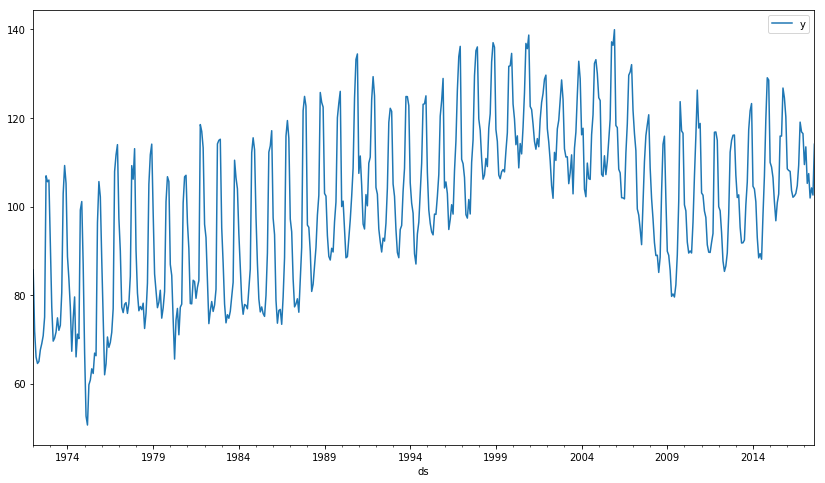

In [4]:
%run setup_workspace.ipynb

In [5]:
data = candy_production
data.head()

ds        y
0 1972-01-01  85.6945
1 1972-02-01  71.8200
2 1972-03-01  66.0229
3 1972-04-01  64.5645
4 1972-05-01  65.0100

# Creating a SARIMA model

## 1. Train-test-split

In [6]:
split_date = pd.Timestamp(date(2016,1,1))
min_date = None
max_date = None

train = data[data.ds < split_date]
if min_date is not None:
    train = train[train['ds'] > min_date]
test = data[data.ds > split_date]

if max_date is not None:
    test = test[test['ds'] < max_date]

In [7]:
# # Plot
# fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# # Usual Differencing
# axes[0].plot(train.y[:], label='Original Series')
# axes[0].plot(train.y[:].diff(1), label='Usual Differencing')
# axes[0].set_title('Usual Differencing')
# axes[0].legend(loc='upper left', fontsize=10)


# # Seasinal Dei
# axes[1].plot(train.y[:], label='Original Series')
# axes[1].plot(train.y[:].diff(12), label='Seasonal Differencing', color='green')
# axes[1].set_title('Seasonal Differencing')
# plt.legend(loc='upper left', fontsize=10)
# plt.suptitle('Candy Production Index', fontsize=16)
# plt.show()

## 2. Model Training

In [8]:
%%time 

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train.y, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=2846.226, BIC=2867.457, Fit time=1.410 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=3446.778, BIC=3455.270, Fit time=0.055 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=2935.097, BIC=2952.081, Fit time=0.995 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=3124.505, BIC=3141.489, Fit time=1.089 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=2842.780, BIC=2868.256, Fit time=2.337 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=2920.290, BIC=2941.521, Fit time=1.386 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=2844.509, BIC=2874.232, Fit time=8.267 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=2995.633, BIC=3012.617, Fit time=0.154 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 12); AIC=2846.401, BIC=2880.370, Fit time=7.578 seconds
Fit ARIMA: order=(0, 0, 1) s

## 3. Forecast 

In [9]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=len(test.ds), return_conf_int=True)

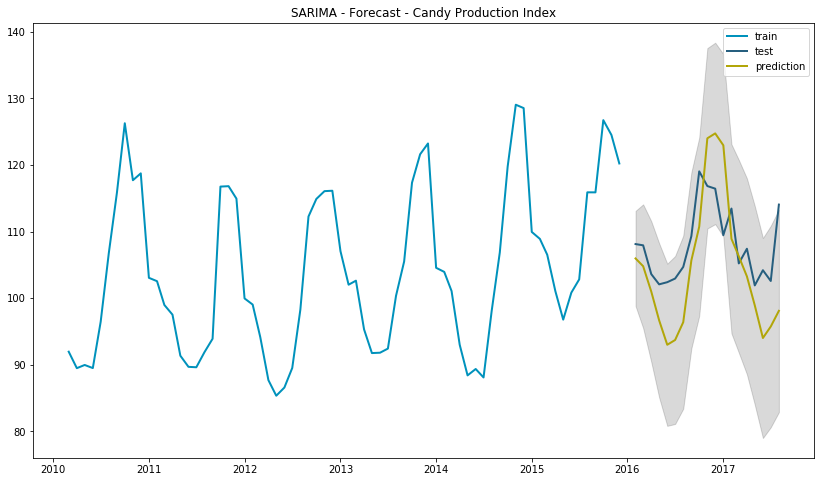

In [12]:
# make series for plotting purpose
index_of_fc = test.ds
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# # Plot
plt.figure(figsize=(14,8))
plt.plot(train.set_index('ds').tail(70), linewidth=2, color = '#0092BC', label='train')
plt.plot(test.set_index('ds'), linewidth=2, color = '#265F7F', label = 'test')
plt.plot(fitted_series, color='#B2A609', linewidth=2, label = 'prediction')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.legend()
plt.title("SARIMA - Forecast - Candy Production Index")
plt.show()

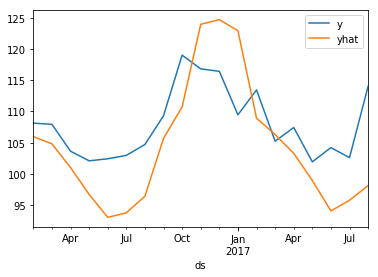

In [13]:
tmp = test.copy()
tmp['yhat'] = fitted_series.values
tmp.set_index('ds', drop=True).plot()

## 4. Evaluation

In [14]:
error = mean_absolute_percentage_error(test.y, fitted_series.values)
print('MAPE:%0.2f%%'%error)

MAPE:6.16%
